 Model Evaluation:
Mean Absolute Error (MAE): 26.60
Root Mean Squared Error (RMSE): 35.50
R² Score: 0.9558

 Wallet Credit Scores:


,userWallet,predicted_score,category
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,387.075648,Risky
1,0x000000000051d07a4fb3bd10121a343d85818da6,395.845725,Risky
2,0x000000000096026fb41fc39f9875d164bd82e2dc,413.207797,Medium
3,0x0000000000e189dd664b9ab08a33c4839953852c,429.707886,Medium
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,58.348562,Risky



 Results saved to /content/wallet_scores.csv


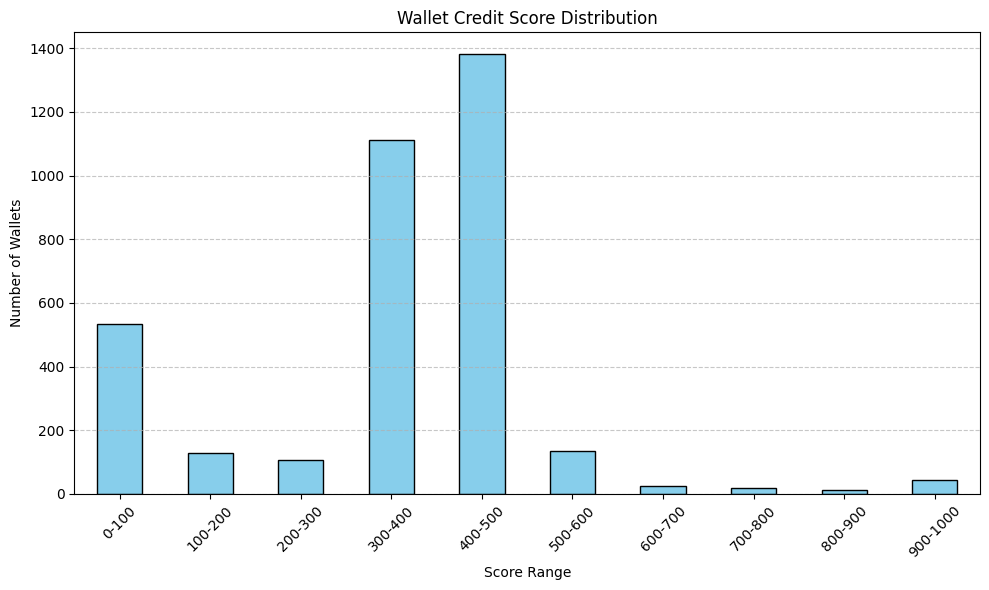


 Wallet Counts by Score Range:
score_bin
0-100        533
100-200      128
200-300      105
300-400     1112
400-500     1381
500-600      135
600-700       26
700-800       20
800-900       12
900-1000      45
Name: count, dtype: int64


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  Function to classify wallets
def classify_wallet(score):
    if score < 400:
        return " Risky"
    elif score < 700:
        return " Medium"
    else:
        return "Good"

#  Loading the JSON file
file_path = '/content/drive/MyDrive/prediction/user-wallet-transactions.json'  # Update if needed
data = pd.read_json(file_path)

#  Feature Engineering
def extract_features(df):
    features = []
    for wallet, group in df.groupby('userWallet'):
        total_tx = len(group)
        deposit_usd = group[group['action'] == 'deposit']['actionData'].apply(
            lambda x: float(x['amount']) * float(x['assetPriceUSD'])).sum()
        borrow_usd = group[group['action'] == 'borrow']['actionData'].apply(
            lambda x: float(x['amount']) * float(x['assetPriceUSD'])).sum()
        repay_usd = group[group['action'] == 'repay']['actionData'].apply(
            lambda x: float(x['amount']) * float(x['assetPriceUSD'])).sum()
        repay_to_borrow = repay_usd / borrow_usd if borrow_usd > 0 else 1
        borrow_to_deposit = borrow_usd / deposit_usd if deposit_usd > 0 else 0
        liquidation_count = (group['action'] == 'liquidationcall').sum()
        active_days = group['timestamp'].apply(lambda x: pd.to_datetime(x, unit='s').date()).nunique()
        tx_times = pd.to_datetime(group['timestamp'], unit='s').sort_values()
        avg_gap_hours = tx_times.diff().dt.total_seconds().mean() / 3600 if len(tx_times) > 1 else 0

        features.append({
            'userWallet': wallet,
            'total_transactions': total_tx,
            'total_deposit_usd': deposit_usd,
            'total_borrow_usd': borrow_usd,
            'repay_to_borrow_ratio': repay_to_borrow,
            'borrow_to_deposit_ratio': borrow_to_deposit,
            'liquidation_count': liquidation_count,
            'active_days': active_days,
            'avg_tx_gap_hours': avg_gap_hours
        })
    return pd.DataFrame(features)

features_df = extract_features(data)

#  Generate synthetic scores for training
np.random.seed(42)
features_df['synthetic_score'] = (
    features_df['repay_to_borrow_ratio'] * 400
    - features_df['liquidation_count'] * 50
    + features_df['borrow_to_deposit_ratio'] * 200
    + np.random.normal(0, 30, size=len(features_df))
).clip(0, 1000)

#  Split data
X = features_df.drop(columns=['userWallet', 'synthetic_score'])
y = features_df['synthetic_score']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#  Train RandomForest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#  Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(" Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

#  Predict scores for all wallets
features_df['predicted_score'] = model.predict(X)
features_df['category'] = features_df['predicted_score'].apply(classify_wallet)

#  Display results
print("\n Wallet Credit Scores:")
display(features_df[['userWallet', 'predicted_score', 'category']].head())

# Save to CSV
features_df[['userWallet', 'predicted_score', 'category']].to_csv(
    '/content/wallet_scores.csv', index=False)
print("\n Results saved to /content/wallet_scores.csv")

# Score distribution
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
labels = ["0-100", "100-200", "200-300", "300-400", "400-500",
          "500-600", "600-700", "700-800", "800-900", "900-1000"]
features_df['score_bin'] = pd.cut(features_df['predicted_score'], bins=bins, labels=labels, include_lowest=True)
score_distribution = features_df['score_bin'].value_counts().sort_index()

#  Plot distribution
plt.figure(figsize=(10,6))
score_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Wallet Credit Score Distribution')
plt.xlabel('Score Range')
plt.ylabel('Number of Wallets')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print distribution
print("\n Wallet Counts by Score Range:")
print(score_distribution)
